# Predicting ICU Length of Stay

### Import packages

In [1]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import numpy as np

import matplotlib.pyplot as plt
import pyodbc

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.ensemble import GradientBoostingRegressor
import math

### Create SQL Database 

This code generates database objects from the very large csv file so that they can be accessed more efficiently

In [2]:
def generate_database(file='MIMIC_III/ADMISSIONS.csv.gz', db_name='csv_database.db', table_name='table', chunksize=100000):
    """
    Converts large .csv files and writes the to an sqlite database in chunks. 
    Inputs: 
        file: the filepath to a table saved as a .csv
        db_name: the desired name of the database object
        table_name: the table name
        chunksize: the number of rows to iteratively write to the sqlite database, making it easier to process
    Output:
        A .db object that can be queryed more quickly 
    """
    
    csv_database = create_engine('sqlite:///'+ db_name)
    i = 0
    j = 1
    for df in pd.read_csv(file, chunksize=chunksize, iterator=True):
          df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
          df.index += j
          i+=1
          df.to_sql(name='table', con=csv_database, if_exists='append')
          j = df.index[-1] + 1

"def generate_database(file='MIMIC_III/ADMISSIONS.csv.gz', db_name='csv_database.db', table_name='table', chunksize=100000):\n    csv_database = create_engine('sqlite:///'+ db_name)\n    i = 0\n    j = 1\n    for df in pd.read_csv(file, chunksize=chunksize, iterator=True):\n          df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) \n          df.index += j\n          i+=1\n          df.to_sql(name='table', con=csv_database, if_exists='append')\n          j = df.index[-1] + 1\n          "

In [3]:
generate_database(file='MIMIC_III/NOTEEVENTS.csv.gz', db_name='NOTEEVENTS.db') 

In [4]:
generate_database(file='MIMIC_III/CHARTEVENTS.csv.gz', db_name='CHARTEVENTS.db') 

In [5]:
# test connection

conn = sqlite3.connect('NOTEEVENTS.db')

query = 'SELECT * FROM [table] where HADM_ID = 131357'

df = pd.read_sql_query(query, conn)

df.head()

"conn = sqlite3.connect('NOTEEVENTS.db')\n\nquery = 'SELECT * FROM [table] where HADM_ID = 131357'\n\ndf = pd.read_sql_query(query, conn)\n\ndf.head()"

### MIMIC Tables

These are the available tables in MIMIC-III, as well as the features that may be useful for predicting LOS

**ADMISSIONS**

*Potentially useful columns:* SUBJECT_ID, HADM_ID, ADMITTIME, DISCHTIME, DEATHTIME (exclude dead), ADMISSION_TYPE,  ADMISSION_LOCATION, DISCHARGE_LOCATION, INSURANCE, RELIGION, MARITAL_STATUS, ETHNICITY, DIAGNOSIS 

**CPTEVENTS**

*Potentially useful columns:* COSTCENTER (either ICU or resp for respiratory, CPT_CD

**DIAGNOSES_ICD**

*Potentially useful columns:* ICD9_CODE, SUBJECT_ID, HADM_ID, SEQ_NUM

**ICUSTAYS**

*Potentially useful columns:* SUBJECT_ID, HADM_ID, FIRST_CAREUNIT, LAST_CAREUNIT, FIRST_WARDID, LAST_WARDID, LOS

**LABEVENTS**

*Potentially useful columns:* SUBJECT_ID, HADM_ID, FLAG (whether laboratory value is abnormal using pre-defined thresholds--I can sum the number of abnormal values perhaps) 

**PATIENTS**

*Potentially useful columns:* GENDER, DOB, SUBJECT_ID, EXPIRE_FLAG (remove those who died)

**PRESCRIPTIONS**

*Potentially useful columns:* SUBJECT_ID, HADM_ID, DRUG, STARTDATE, ENDDATE (will be used to calculate prescription length)

**PROCEDURES_ICD**

*Potentially useful columns:* SUBJECT_ID, HADM_ID, SEQ_NUM, ICD9_CODE

**SERVICES**

*Potentially useful columns:* SUBJECT_ID, HADM_ID, PREV_SERVICE, CURR_SERVICE

### Import potentially useful features from tables

In [6]:
ADMISSIONS_df = pd.read_csv('MIMIC_III/ADMISSIONS.csv.gz')

ADMISSIONS_df_useful = ADMISSIONS_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 
                           'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 
                           'ETHNICITY', 'DIAGNOSIS']] 

In [150]:
CPTEVENTS_df = pd.read_csv('MIMIC_III/CPTEVENTS.csv.gz')

CPTEVENTS_df_useful = CPTEVENTS_df[['HADM_ID', 'CPT_CD']] 

In [8]:
DIAGNOSES_ICD_df = pd.read_csv('MIMIC_III/DIAGNOSES_ICD.csv.gz')

DIAGNOSES_ICD_df_useful = DIAGNOSES_ICD_df[['ICD9_CODE', 'HADM_ID']] 

In [9]:
ICUSTAYS_df = pd.read_csv('MIMIC_III/ICUSTAYS.csv.gz')

ICUSTAYS_df_useful = ICUSTAYS_df[['SUBJECT_ID', 'HADM_ID', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID',
                                  'LAST_WARDID', 'LOS']] 

In [372]:
INPUTEVENTS_MV_df = pd.read_csv('MIMIC_III/INPUTEVENTS_MV.csv.gz')

INPUTEVENTS_MV_df_useful = INPUTEVENTS_MV_df[['HADM_ID', 'PATIENTWEIGHT']]

In [10]:
LABEVENTS_df = pd.read_csv('MIMIC_III/LABEVENTS.csv.gz')

LABEVENTS_df_useful = LABEVENTS_df[['SUBJECT_ID', 'HADM_ID', 'FLAG']] 

In [11]:
PATIENTS_df = pd.read_csv('MIMIC_III/PATIENTS.csv.gz')

PATIENTS_df_useful = PATIENTS_df[['GENDER', 'DOB', 'SUBJECT_ID', 'EXPIRE_FLAG']] 
#PATIENTS_df_useful = PATIENTS_df_useful.loc[PATIENTS_df_useful.EXPIRE_FLAG == 0] # remove the dead ones

In [12]:
PRESCRIPTIONS_df = pd.read_csv('MIMIC_III/PRESCRIPTIONS.csv.gz')

PRESCRIPTIONS_df_useful = PRESCRIPTIONS_df[['SUBJECT_ID', 'HADM_ID', 'DRUG', 'STARTDATE', 'ENDDATE']] 

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
PROCEDURES_ICD_df = pd.read_csv('MIMIC_III/PROCEDURES_ICD.csv.gz')

PROCEDURES_ICD_df_useful = PROCEDURES_ICD_df[['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']] 

In [14]:
SERVICES_df = pd.read_csv('MIMIC_III/SERVICES.csv.gz')

SERVICES_useful = SERVICES_df[['SUBJECT_ID', 'HADM_ID', 'PREV_SERVICE', 'CURR_SERVICE']] 

### Wrangle to Patient Rows

In [15]:
# verify one diagnosis per patient and admission
ADMISSIONS_df_useful.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME


In [297]:
len(ADMISSIONS_df_useful)

58976

In [301]:
ADMISSIONS_df_useful_live = ADMISSIONS_df_useful.loc[ADMISSIONS_df_useful.DEATHTIME.isnull()].copy()
len(ADMISSIONS_df_useful_live)

53122

In [303]:
ADMISSIONS_df_useful_live[['SUBJECT_ID', 'HADM_ID']].nunique()

SUBJECT_ID    42131
HADM_ID       53122
dtype: int64

In [18]:
len(ADMISSIONS_df_useful[['SUBJECT_ID', 'HADM_ID']].drop_duplicates())

58976

In [19]:
# This is not single row per subject level
CPTEVENTS_df_useful.head()

,SUBJECT_ID,HADM_ID,COSTCENTER,CPT_CD
0,11743,129545,ICU,99232
1,11743,129545,ICU,99232
2,11743,129545,ICU,99232
3,11743,129545,ICU,99232
4,6185,183725,ICU,99223


In [20]:
CPTEVENTS_df_trimmed = CPTEVENTS_df_useful.drop_duplicates()
len(CPTEVENTS_df_trimmed)

227510

In [21]:
len(CPTEVENTS_df_trimmed)

227510

In [22]:
CPTEVENTS_df_trimmed.HADM_ID.nunique()

44148

In [23]:
CPTEVENTS_df_trimmed.CPT_CD.describe()

count     227510
unique      3060
top        99291
freq       16071
Name: CPT_CD, dtype: object

In [25]:
ICUSTAYS_df_useful.HADM_ID.nunique()

57786

In [26]:
ICUSTAYS_df_useful.SUBJECT_ID.nunique()

46476

In [27]:
ICUSTAYS_df_trimmed = ICUSTAYS_df_useful.drop_duplicates()

In [28]:
len(ICUSTAYS_df_useful)

61532

In [29]:
len(ICUSTAYS_df_trimmed)

61532

In [30]:
len(ICUSTAYS_df_trimmed[['SUBJECT_ID', 'HADM_ID']].drop_duplicates())

57786

In [31]:
ICUSTAYS_df_trimmed.head()

,SUBJECT_ID,HADM_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,LOS
0,268,110404,MICU,MICU,52,52,3.2490
1,269,106296,MICU,MICU,52,52,3.2788
2,270,188028,CCU,CCU,57,57,2.8939
3,271,173727,MICU,SICU,52,23,2.0600
4,272,164716,CCU,CCU,57,57,1.6202


### Patient Weight

In [375]:
INPUTEVENTS_MV_df_useful2 = INPUTEVENTS_MV_df_useful.drop_duplicates()

len(INPUTEVENTS_MV_df_useful2)

24108

We only have patient weights for 24K patients, so I will not include this feature. 

### Number of CPT codes per visit

In [304]:
len(CPTEVENTS_df_useful.loc[CPTEVENTS_df_useful.HADM_ID == 129545])

13

In [305]:
num_cpt_events = CPTEVENTS_df_useful.groupby('HADM_ID').count()
num_cpt_events.reset_index(level=0, inplace=True)
num_cpt_events.rename(columns={'CPT_CD': 'COUNT_CPT_CD'}, inplace=True)

In [306]:
num_cpt_events.loc[num_cpt_events.HADM_ID == 129545]

,HADM_ID,COUNT_CPT_CD
13068,129545,13


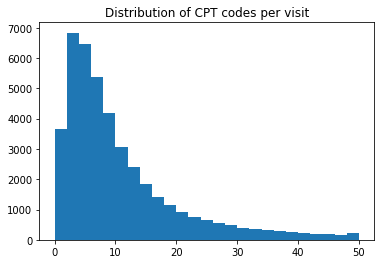

In [425]:
plt.hist(num_cpt_events.COUNT_CPT_CD, bins=25, range=[0,50])
plt.title('Distribution of CPT codes per visit')
plt.show()

In [308]:
len(num_cpt_events)

44148

### the first version will just have ICU stays and the basic patient info: admissions, patients, icustays

/home/INTSURG/robertmo/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/INTSURG/robertmo/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


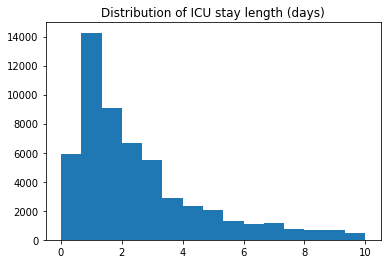

In [309]:
# will revisit when this is just the patients I'm interested in
plt.hist(ICUSTAYS_df_trimmed.LOS, bins=15, range=[0,10])
plt.title('Distribution of ICU stay length (days)')
plt.show()

In [310]:
# merge the tables together

combined = pd.merge(ADMISSIONS_df_useful_live, ICUSTAYS_df_trimmed, how='inner', on='HADM_ID')
combined.drop('SUBJECT_ID_x', inplace=True, axis=1)
combined.rename(columns={'SUBJECT_ID_y':'SUBJECT_ID'}, inplace=True)

combined0 = pd.merge(combined, DIAGNOSES_ICD_df_useful, how='inner', on='HADM_ID')

combined1 = pd.merge(combined0, num_cpt_events, how='inner', on='HADM_ID')

combined2 = pd.merge(combined1, PATIENTS_df, how='left', on='SUBJECT_ID')
combined2.head()

,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,SUBJECT_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,LOS,ICD9_CODE,COUNT_CPT_CD,ROW_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,23,SICU,SICU,57,57,1.1862,2252,6,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
1,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,23,SICU,SICU,57,57,1.1862,3485,6,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
2,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,23,SICU,SICU,57,57,1.1862,78039,6,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
3,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,23,SICU,SICU,57,57,1.1862,4241,6,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
4,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,23,SICU,SICU,57,57,1.1862,4019,6,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0


In [312]:
# change dates to proper data type
combined2['ADMITTIME'] = pd.to_datetime(combined2['ADMITTIME'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
combined2['DISCHTIME'] = pd.to_datetime(combined2['DISCHTIME'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
combined2['DOB'] = pd.to_datetime(combined2['DOB'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

### Create features

We can take the specific ICD9 codes and go a level up to the category level. Those starting with "E" are external accidents. These are highly variable--an accident on a playground may or may not be remotely similar to one with industrial manufacturing equipment. 

"V" codes are supplementary classification factors influencing health status. These could also be highly variable. 

The following is a list of codes for International Statistical Classification of Diseases and Related Health Problems 

List of ICD-9 codes 001–139: infectious and parasitic diseases

List of ICD-9 codes 140–239: neoplasms

List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders

List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs

List of ICD-9 codes 290–319: mental disorders

List of ICD-9 codes 320–389: diseases of the nervous system and sense organs

List of ICD-9 codes 390–459: diseases of the circulatory system

List of ICD-9 codes 460–519: diseases of the respiratory system

List of ICD-9 codes 520–579: diseases of the digestive system

List of ICD-9 codes 580–629: diseases of the genitourinary system

List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium

List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue

List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue

List of ICD-9 codes 740–759: congenital anomalies

List of ICD-9 codes 760–779: certain conditions originating in the perinatal period

List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions

List of ICD-9 codes 800–999: injury and poisoning

List of ICD-9 codes E and V codes: external causes of injury and supplemental classification

In [313]:
def icd9_mapper(n):
    """
    Maps the diagnoses category using the first 3 digits of the ICD9 Code
    Input: a full ICD9 code (this is meant to be applied element-wise to a Pandas column)
    Output: the ICD9 category
    """
     
    x = str(n) # convert to subscriptable
    if x[0] == 'E':
        y = 'External'
    elif x[0] == 'V':
        y = 'Supplemental'
    elif x[0:2] == '00':
        y = 'infectious and parasitic diseases'
    
    elif x.isnumeric():
        if int(x[0:3]) in list(range(1, (139+1))): 
            y = 'infectious and parasitic diseases'
        elif int(x[0:3]) in list(range(140, (239+1))):
            y = 'neoplasms' 
        elif int(x[0:3]) in list(range(240, (279+1))):
            y = 'endocrine, nutritional and metabolic, and immunity'
        elif int(x[0:3]) in list(range(280, (289+1))):
            y = 'blood and blood-forming organs'
        elif int(x[0:3]) in list(range(290, (319+1))):
            y = 'mental disorders'
        elif int(x[0:3]) in list(range(320, (389+1))):
            y = 'nervous system and sense organs'
        elif int(x[0:3]) in list(range(390, (459+1))):
            y = 'circulatory system'
        elif int(x[0:3]) in list(range(460, (519+1))):
            y = 'respiratory system'
        elif int(x[0:3]) in list(range(520, (579+1))):
            y = 'digestive system'
        elif int(x[0:3]) in list(range(580, (629+1))):
            y = 'genitourinary system'
        elif int(x[0:3]) in list(range(630, (679+1))):
            y = 'complications of pregnancy, childbirth, and the puerperium'
        elif int(x[0:3]) in list(range(680, (709+1))):
            y = 'skin and subcutaneous tissue'
        elif int(x[0:3]) in list(range(710, (739+1))):
            y = 'musculoskeletal system and connective tissue'
        elif int(x[0:3]) in list(range(740, (759+1))):
            y = 'congenital anomalies'
        elif int(x[0:3]) in list(range(760, (779+1))):
            y = 'conditions originating in the perinatal period'
        elif int(x[0:3]) in list(range(780, (799+1))):
            y = 'symptoms, signs, and ill-defined conditions'
        elif int(x[0:3]) in list(range(800, (999+1))):
            y = 'injury and poisoning'
    
    elif type(n) == str: # other strings that can't be converted to integers
        y = 'Other'
    
    elif math.isnan(n):
        y = 'Other'
    return y

In [314]:
combined2['ICD9_Category'] = combined2['ICD9_CODE'].map(icd9_mapper)

In [315]:
combined2[['ICD9_CODE', 'ICD9_Category']]

,ICD9_CODE,ICD9_Category
0,2252,neoplasms
1,3485,nervous system and sense organs
2,78039,"symptoms, signs, and ill-defined conditions"
3,4241,circulatory system
4,4019,circulatory system
5,2720,"endocrine, nutritional and metabolic, and immu..."
6,2724,"endocrine, nutritional and metabolic, and immu..."
7,V4581,Supplemental
8,V4579,Supplemental
9,V1582,Supplemental


In [316]:
# LOS calc
combined2['TrueLOS'] = (combined2['DISCHTIME'] - combined2['ADMITTIME']).dt.total_seconds()/86400

In [317]:
combined2['admitdate'] = combined2['ADMITTIME'].dt.date
combined2['admitdate'] = pd.to_datetime(combined2['admitdate'], format='%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [318]:
combined2['DOB'] = combined2['DOB'].dt.date
combined2['admitdate'] = combined2['admitdate'].dt.date

In [319]:
combined2['Age'] = (combined2['admitdate'] - combined2['DOB'])
combined2['Age'] = round(combined2.Age.apply(lambda x: x.days/365), 0) # for some reason, couldn't use .days on the column, so used lambda function


combined2[['admitdate', 'DOB', 'ADMITTIME', 'Age']].head() 

,admitdate,DOB,ADMITTIME,Age
0,2157-10-18,2082-07-17,2157-10-18 19:34:00,75.0
1,2157-10-18,2082-07-17,2157-10-18 19:34:00,75.0
2,2157-10-18,2082-07-17,2157-10-18 19:34:00,75.0
3,2157-10-18,2082-07-17,2157-10-18 19:34:00,75.0
4,2157-10-18,2082-07-17,2157-10-18 19:34:00,75.0


### Pivot Diagnoses

In [320]:
to_pivot = combined2[['HADM_ID', 'ICD9_Category']]
to_pivot.head()

,HADM_ID,ICD9_Category
0,124321,neoplasms
1,124321,nervous system and sense organs
2,124321,"symptoms, signs, and ill-defined conditions"
3,124321,circulatory system
4,124321,circulatory system


In [321]:
pivoted = to_pivot.pivot_table(index='HADM_ID', columns='ICD9_Category', aggfunc=len, fill_value=0)
pivoted.head(15)

ICD9_Category,External,Other,Supplemental,blood and blood-forming organs,circulatory system,"complications of pregnancy, childbirth, and the puerperium",conditions originating in the perinatal period,congenital anomalies,digestive system,"endocrine, nutritional and metabolic, and immunity",genitourinary system,infectious and parasitic diseases,injury and poisoning,mental disorders,musculoskeletal system and connective tissue,neoplasms,nervous system and sense organs,respiratory system,skin and subcutaneous tissue,"symptoms, signs, and ill-defined conditions"
HADM_ID,,,,,,,,,,,,,,,,,,,,
100001,0,0,2,0,2,0,0,0,2,5,2,0,0,0,0,0,2,0,1,0
100003,0,0,0,1,2,0,0,0,4,0,0,1,0,0,0,0,0,0,0,1
100006,0,0,2,0,0,0,0,0,0,1,0,0,0,1,0,1,0,3,0,1
100007,0,0,0,0,1,0,0,0,2,0,0,0,1,0,0,0,0,1,0,0
100009,0,0,6,1,7,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0
100010,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,0,0,0,0
100011,1,0,0,1,0,0,0,0,0,0,0,0,10,1,0,0,0,1,0,0
100012,1,0,5,0,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
100016,0,0,1,0,1,0,0,1,1,2,0,0,0,1,0,0,1,3,0,0


In [322]:
# get rid of icd9 columns and drop, then join the pivoted table 
# a better solution would be to pivot data before joining initially

combined2.drop(['ICD9_Category', 'ICD9_CODE'], axis=1, inplace=True)
combined3 = combined2.drop_duplicates()
combined3.head()

,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,SUBJECT_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,LOS,COUNT_CPT_CD,ROW_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,TrueLOS,admitdate,Age
0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,23,SICU,SICU,57,57,1.1862,6,20,M,2082-07-17,NaN,NaN,NaN,0,6.768056,2157-10-18,75.0
10,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,24,CCU,CCU,7,7,0.5124,4,21,M,2100-05-31,NaN,NaN,NaN,0,2.856944,2139-06-06,39.0
14,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,25,CCU,CCU,7,7,3.5466,4,22,M,2101-11-21,NaN,NaN,NaN,0,3.534028,2160-11-02,59.0
18,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,V-TACH,26,CCU,CCU,57,57,2.1407,5,23,M,2054-05-04,2128-02-25 00:00:00,NaN,2128-02-25 00:00:00,1,6.988889,2126-05-06,72.0
27,176176,2116-12-23 22:30:00,2116-12-27 12:05:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,PROTESTANT QUAKER,MARRIED,UNKNOWN/NOT SPECIFIED,SEPSIS;TELEMETRY,33,MICU,MICU,12,12,1.5542,3,29,M,2034-08-02,NaN,NaN,NaN,0,3.565972,2116-12-23,82.0


In [323]:
combined4 = pd.merge(combined3, pivoted, on='HADM_ID', how='inner')
len(combined4)

41156

In [324]:
combined4.head()

,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,SUBJECT_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,LOS,COUNT_CPT_CD,ROW_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,TrueLOS,admitdate,Age,External,Other,Supplemental,blood and blood-forming organs,circulatory system,"complications of pregnancy, childbirth, and the puerperium",conditions originating in the perinatal period,congenital anomalies,digestive system,"endocrine, nutritional and metabolic, and immunity",genitourinary system,infectious and parasitic diseases,injury and poisoning,mental disorders,musculoskeletal system and connective tissue,neoplasms,nervous system and sense organs,respiratory system,skin and subcutaneous tissue,"symptoms, signs, and ill-defined conditions"
0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,23,SICU,SICU,57,57,1.1862,6,20,M,2082-07-17,NaN,NaN,NaN,0,6.768056,2157-10-18,75.0,0,0,3,0,2,0,0,0,0,2,0,0,0,0,0,1,1,0,0,1
1,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,24,CCU,CCU,7,7,0.5124,4,21,M,2100-05-31,NaN,NaN,NaN,0,2.856944,2139-06-06,39.0,0,0,0,0,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,25,CCU,CCU,7,7,3.5466,4,22,M,2101-11-21,NaN,NaN,NaN,0,3.534028,2160-11-02,59.0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,V-TACH,26,CCU,CCU,57,57,2.1407,5,23,M,2054-05-04,2128-02-25 00:00:00,NaN,2128-02-25 00:00:00,1,6.988889,2126-05-06,72.0,0,0,0,0,5,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0
4,176176,2116-12-23 22:30:00,2116-12-27 12:05:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,PROTESTANT QUAKER,MARRIED,UNKNOWN/NOT SPECIFIED,SEPSIS;TELEMETRY,33,MICU,MICU,12,12,1.5542,3,29,M,2034-08-02,NaN,NaN,NaN,0,3.565972,2116-12-23,82.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0


### Export raw data

In [325]:
combined4.to_csv('intermediatetable_12-13-19.csv') # exporting for visualization/exploration in Tableau

In [326]:
combined4.DOD.notnull().sum()

15264

### Remove unncessary features

In [327]:
combined5 = combined4.drop(['HADM_ID','ADMITTIME', 'DEATHTIME', 'DISCHTIME', 'SUBJECT_ID', 'ROW_ID', 'DOD', 'DOD_HOSP',
                         'DOD_SSN', 'admitdate', 'LOS', 'FIRST_WARDID', 'LAST_WARDID', 'DOB', 'DIAGNOSIS'], axis=1)

combined6 = combined5[combined5['TrueLOS'].notnull()]

combined6.isnull().sum()

ADMISSION_TYPE                                                   0
ADMISSION_LOCATION                                               0
DISCHARGE_LOCATION                                               0
INSURANCE                                                        0
RELIGION                                                       103
MARITAL_STATUS                                                1699
ETHNICITY                                                        0
FIRST_CAREUNIT                                                   0
LAST_CAREUNIT                                                    0
COUNT_CPT_CD                                                     0
GENDER                                                           0
EXPIRE_FLAG                                                      0
TrueLOS                                                          0
Age                                                              0
External                                                      

In [328]:
combined6.RELIGION.fillna('UNKNOWN (DEFAULT)', inplace=True)
combined6.MARITAL_STATUS.fillna('UNKNOWN (DEFAULT)', inplace=True)

In [329]:
combined6.isnull().sum()

ADMISSION_TYPE                                                0
ADMISSION_LOCATION                                            0
DISCHARGE_LOCATION                                            0
INSURANCE                                                     0
RELIGION                                                      0
MARITAL_STATUS                                                0
ETHNICITY                                                     0
FIRST_CAREUNIT                                                0
LAST_CAREUNIT                                                 0
COUNT_CPT_CD                                                  0
GENDER                                                        0
EXPIRE_FLAG                                                   0
TrueLOS                                                       0
Age                                                           0
External                                                      0
Other                                   

### Understand Features

In [ ]:
combined6['Age'].astype('int')
combined6.describe()

In [331]:
# remove observations with a negative LOS or ridiculous age
combined8 = combined6.loc[combined6.TrueLOS >= 0]
combined9 = combined8.loc[combined8.Age <= 120]

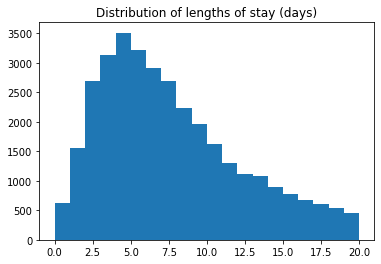

In [332]:
plt.hist(combined9.TrueLOS, bins=20, range=[0, 20]) 
plt.title('Distribution of lengths of stay (days)')
plt.show()

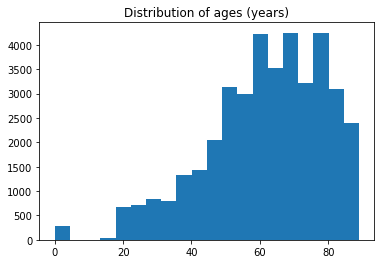

In [333]:
plt.hist(combined9.Age, bins=20) 
plt.title('Distribution of ages (years)')
plt.show()

In [334]:
for i in combined9.columns:
    print(i + ': ')
    print(combined6[i].unique())

ADMISSION_TYPE: 
['EMERGENCY' 'ELECTIVE' 'URGENT' 'NEWBORN']
ADMISSION_LOCATION: 
['TRANSFER FROM HOSP/EXTRAM' 'EMERGENCY ROOM ADMIT'
 'CLINIC REFERRAL/PREMATURE' 'PHYS REFERRAL/NORMAL DELI'
 'TRANSFER FROM SKILLED NUR' 'TRANSFER FROM OTHER HEALT'
 '** INFO NOT AVAILABLE **' 'HMO REFERRAL/SICK'
 'TRSF WITHIN THIS FACILITY']
DISCHARGE_LOCATION: 
['HOME HEALTH CARE' 'HOME' 'REHAB/DISTINCT PART HOSP'
 'LONG TERM CARE HOSPITAL' 'DISC-TRAN TO FEDERAL HC' 'SNF'
 'DISC-TRAN CANCER/CHLDRN H' 'HOSPICE-MEDICAL FACILITY'
 'HOME WITH HOME IV PROVIDR' 'HOSPICE-HOME' 'LEFT AGAINST MEDICAL ADVI'
 'DISCH-TRAN TO PSYCH HOSP' 'SHORT TERM HOSPITAL' 'OTHER FACILITY' 'ICF'
 'SNF-MEDICAID ONLY CERTIF']
INSURANCE: 
['Medicare' 'Private' 'Self Pay' 'Government' 'Medicaid']
RELIGION: 
['CATHOLIC' 'PROTESTANT QUAKER' 'UNOBTAINABLE' 'NOT SPECIFIED' 'JEWISH'
 'BUDDHIST' "JEHOVAH'S WITNESS" 'OTHER' 'UNKNOWN (DEFAULT)'
 'GREEK ORTHODOX' 'EPISCOPALIAN' 'CHRISTIAN SCIENTIST' 'METHODIST'
 'UNITARIAN-UNIVERSALIST' 'HIN

### Feature Consolidation

Some features have far too many buckets to convert to dummy variables, meaning we have to consolidate them. 

In [335]:
combined9.ADMISSION_LOCATION.unique()

array(['TRANSFER FROM HOSP/EXTRAM', 'EMERGENCY ROOM ADMIT',
       'PHYS REFERRAL/NORMAL DELI', 'CLINIC REFERRAL/PREMATURE',
       'TRANSFER FROM SKILLED NUR', 'TRANSFER FROM OTHER HEALT',
       '** INFO NOT AVAILABLE **', 'HMO REFERRAL/SICK',
       'TRSF WITHIN THIS FACILITY'], dtype=object)

In [336]:
# ADMISSION_LOCATION

combined9.loc[combined9.ADMISSION_LOCATION == '** INFO NOT AVAILABLE **', 'ADMISSION_LOCATION'] = 'OTHER'
combined9.loc[combined9.ADMISSION_LOCATION == 'HMO REFERRAL/SICK', 'ADMISSION_LOCATION'] = 'OTHER'

combined9.loc[combined9.ADMISSION_LOCATION == 'TRANSFER FROM HOSP/EXTRAM', 'ADMISSION_LOCATION'] = 'TRANSFER'
combined9.loc[combined9.ADMISSION_LOCATION == 'TRSF WITHIN THIS FACILITY', 'ADMISSION_LOCATION'] = 'TRANSFER'
combined9.loc[combined9.ADMISSION_LOCATION == 'TRANSFER FROM OTHER HEALT', 'ADMISSION_LOCATION'] = 'TRANSFER'
combined9.loc[combined9.ADMISSION_LOCATION == 'TRANSFER FROM SKILLED NUR', 'ADMISSION_LOCATION'] = 'TRANSFER'

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [337]:
combined9.ADMISSION_LOCATION.unique()

array(['TRANSFER', 'EMERGENCY ROOM ADMIT', 'PHYS REFERRAL/NORMAL DELI',
       'CLINIC REFERRAL/PREMATURE', 'OTHER'], dtype=object)

In [338]:
# DISCHARGE LOCATION

combined9.loc[combined9.DISCHARGE_LOCATION == 'HOME HEALTH CARE', 'DISCHARGE_LOCATION'] = 'HOME HEALTHCARE'
combined9.loc[combined9.DISCHARGE_LOCATION == 'HOME WITH HOME IV PROVIDR', 'DISCHARGE_LOCATION'] = 'HOME HEALTHCARE'
combined9.loc[combined9.DISCHARGE_LOCATION == 'HOSPICE-HOME', 'DISCHARGE_LOCATION'] = 'HOME HEALTHCARE'
combined9.loc[combined9.DISCHARGE_LOCATION == 'HOSPICE-MEDICAL FACILITY', 'DISCHARGE_LOCATION'] = 'HOME HEALTHCARE'

combined9.loc[combined9.DISCHARGE_LOCATION == 'DISC-TRAN CANCER/CHLDRN H', 'DISCHARGE_LOCATION'] = 'OTHER'
combined9.loc[combined9.DISCHARGE_LOCATION == 'DISC-TRAN TO FEDERAL HC', 'DISCHARGE_LOCATION'] = 'OTHER'
combined9.loc[combined9.DISCHARGE_LOCATION == 'DISCH-TRAN TO PSYCH HOSP', 'DISCHARGE_LOCATION'] = 'OTHER'
combined9.loc[combined9.DISCHARGE_LOCATION == 'ICF', 'DISCHARGE_LOCATION'] = 'OTHER'
combined9.loc[combined9.DISCHARGE_LOCATION == 'LEFT AGAINST MEDICAL ADVI', 'DISCHARGE_LOCATION'] = 'OTHER'
combined9.loc[combined9.DISCHARGE_LOCATION == 'OTHER FACILITY', 'DISCHARGE_LOCATION'] = 'OTHER'

combined9.loc[combined9.DISCHARGE_LOCATION == 'SNF-MEDICAID ONLY CERTIF', 'DISCHARGE_LOCATION'] = 'SNF'

In [339]:
combined9.DISCHARGE_LOCATION.unique()

array(['HOME HEALTHCARE', 'HOME', 'REHAB/DISTINCT PART HOSP',
       'LONG TERM CARE HOSPITAL', 'OTHER', 'SNF', 'SHORT TERM HOSPITAL'],
      dtype=object)

In [340]:
# RELIGION

combined9.loc[combined9.RELIGION == 'HEBREW', 'RELIGION'] = 'JEWISH'

combined9.loc[combined9.RELIGION == 'GREEK ORTHODOX', 'RELIGION'] = 'ORTHODOX'
combined9.loc[combined9.RELIGION == 'ROMANIAN EAST. ORTH', 'RELIGION'] = 'ORTHODOX'

combined9.loc[combined9.RELIGION == '7TH DAY ADVENTIST', 'RELIGION'] = 'OTHER'
combined9.loc[combined9.RELIGION == 'BUDDHIST', 'RELIGION'] = 'OTHER'
combined9.loc[combined9.RELIGION == 'HINDU', 'RELIGION'] = 'OTHER'
combined9.loc[combined9.RELIGION == "JEHOVAH'S WITNESS", 'RELIGION'] = 'OTHER'
combined9.loc[combined9.RELIGION == 'MUSLIM', 'RELIGION'] = 'OTHER'
combined9.loc[combined9.RELIGION == 'OTHER', 'RELIGION'] = 'OTHER'
combined9.loc[combined9.RELIGION == 'UNITARIAN-UNIVERSALIST', 'RELIGION'] = 'OTHER'

combined9.loc[combined9.RELIGION == 'BAPTIST', 'RELIGION'] = 'PROTESTANT'
combined9.loc[combined9.RELIGION == 'CHRISTIAN SCIENTIST', 'RELIGION'] = 'PROTESTANT'
combined9.loc[combined9.RELIGION == 'EPISCOPALIAN', 'RELIGION'] = 'PROTESTANT'
combined9.loc[combined9.RELIGION == 'LUTHERAN', 'RELIGION'] = 'PROTESTANT'
combined9.loc[combined9.RELIGION == 'METHODIST', 'RELIGION'] = 'PROTESTANT'
combined9.loc[combined9.RELIGION == 'PROTESTANT QUAKER', 'RELIGION'] = 'PROTESTANT'

combined9['RELIGION'].fillna('UNKNOWN')
combined9.loc[combined9.RELIGION == 'NOT SPECIFIED', 'RELIGION'] = 'UNKNOWN'
combined9.loc[combined9.RELIGION == 'UNOBTAINABLE', 'RELIGION'] = 'UNKNOWN'
combined9.loc[combined9.RELIGION == 'UNKNOWN (DEFAULT)', 'RELIGION'] = 'UNKNOWN'

In [341]:
combined9.RELIGION.unique()

array(['CATHOLIC', 'PROTESTANT', 'UNKNOWN', 'JEWISH', 'OTHER', 'ORTHODOX'],
      dtype=object)

In [342]:
# RELIGION

combined9.loc[combined9.MARITAL_STATUS == 'LIFE PARTNER', 'MARITAL_STATUS'] = 'MARRIED'
combined9.loc[combined9.MARITAL_STATUS == 'LIFE PARTNER', 'MARITAL_STATUS'] = 'MARRIED'

combined9['MARITAL_STATUS'].fillna('UNKNOWN')
combined9.loc[combined9.MARITAL_STATUS == 'UNKNOWN (DEFAULT)', 'MARITAL_STATUS'] = 'UNKNOWN'

combined9.loc[combined9.MARITAL_STATUS == 'SEPARATED', 'MARITAL_STATUS'] = 'WIDOWED'

In [343]:
combined9.MARITAL_STATUS.unique()

array(['MARRIED', 'SINGLE', 'DIVORCED', 'WIDOWED', 'UNKNOWN'],
      dtype=object)

In [344]:
# ETHNICITY

combined9.loc[combined9.ETHNICITY == 'ASIAN - ASIAN INDIAN', 'ETHNICITY'] = 'ASIAN'
combined9.loc[combined9.ETHNICITY == 'ASIAN - CAMBODIAN', 'ETHNICITY'] = 'ASIAN'
combined9.loc[combined9.ETHNICITY == 'ASIAN - CHINESE', 'ETHNICITY'] = 'ASIAN'
combined9.loc[combined9.ETHNICITY == 'ASIAN - FILIPINO', 'ETHNICITY'] = 'ASIAN'
combined9.loc[combined9.ETHNICITY == 'ASIAN - JAPANESE', 'ETHNICITY'] = 'ASIAN'
combined9.loc[combined9.ETHNICITY == 'ASIAN - KOREAN', 'ETHNICITY'] = 'ASIAN'
combined9.loc[combined9.ETHNICITY == 'ASIAN - OTHER', 'ETHNICITY'] = 'ASIAN'
combined9.loc[combined9.ETHNICITY == 'ASIAN - THAI', 'ETHNICITY'] = 'ASIAN'
combined9.loc[combined9.ETHNICITY == 'ASIAN - VIETNAMESE', 'ETHNICITY'] = 'ASIAN'

combined9.loc[combined9.ETHNICITY == 'BLACK/AFRICAN', 'ETHNICITY'] = 'BLACK'
combined9.loc[combined9.ETHNICITY == 'BLACK/AFRICAN AMERICAN', 'ETHNICITY'] = 'BLACK'
combined9.loc[combined9.ETHNICITY == 'BLACK/CAPE VERDEAN', 'ETHNICITY'] = 'BLACK'
combined9.loc[combined9.ETHNICITY == 'BLACK/HAITIAN', 'ETHNICITY'] = 'BLACK'
combined9.loc[combined9.ETHNICITY == 'CARIBBEAN ISLAND', 'ETHNICITY'] = 'BLACK'

combined9.loc[combined9.ETHNICITY == 'HISPANIC OR LATINO', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - COLOMBIAN', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - CUBAN', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - CUBAN', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - DOMINICAN', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - GUATEMALAN', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - HONDURAN', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - MEXICAN', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - PUERTO RICAN', 'ETHNICITY'] = 'HISPANIC'
combined9.loc[combined9.ETHNICITY == 'HISPANIC/LATINO - SALVADORAN', 'ETHNICITY'] = 'HISPANIC'

combined9.loc[combined9.ETHNICITY == 'AMERICAN INDIAN/ALASKA NATIVE', 'ETHNICITY'] = 'OTHER'
combined9.loc[combined9.ETHNICITY == 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'ETHNICITY'] = 'OTHER'
combined9.loc[combined9.ETHNICITY == 'MIDDLE EASTERN', 'ETHNICITY'] = 'OTHER'
combined9.loc[combined9.ETHNICITY == 'MULTI RACE ETHNICITY', 'ETHNICITY'] = 'OTHER'
combined9.loc[combined9.ETHNICITY == 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ETHNICITY'] = 'OTHER'
combined9.loc[combined9.ETHNICITY == 'PORTUGUESE', 'ETHNICITY'] = 'OTHER'
combined9.loc[combined9.ETHNICITY == 'SOUTH AMERICAN', 'ETHNICITY'] = 'OTHER'

combined9.loc[combined9.ETHNICITY == 'PATIENT DECLINED TO ANSWER', 'ETHNICITY'] = 'UNKNOWN'
combined9.loc[combined9.ETHNICITY == 'UNABLE TO OBTAIN', 'ETHNICITY'] = 'UNKNOWN'
combined9.loc[combined9.ETHNICITY == 'UNKNOWN/NOT SPECIFIED', 'ETHNICITY'] = 'UNKNOWN'

combined9.loc[combined9.ETHNICITY == 'WHITE - BRAZILIAN', 'ETHNICITY'] = 'WHITE'
combined9.loc[combined9.ETHNICITY == 'WHITE - EASTERN EUROPEAN', 'ETHNICITY'] = 'WHITE'
combined9.loc[combined9.ETHNICITY == 'WHITE - OTHER EUROPEAN', 'ETHNICITY'] = 'WHITE'
combined9.loc[combined9.ETHNICITY == 'WHITE - RUSSIAN', 'ETHNICITY'] = 'WHITE'

In [345]:
combined9.ETHNICITY.unique()

array(['WHITE', 'UNKNOWN', 'OTHER', 'HISPANIC', 'BLACK', 'ASIAN'],
      dtype=object)

### One Hot Encoding

Next, we will convert the categorical features into dummy variables

In [346]:
combined9.columns

Index(['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'COUNT_CPT_CD', 'GENDER',
       'EXPIRE_FLAG', 'TrueLOS', 'Age', 'External', 'Other', 'Supplemental',
       'blood and blood-forming organs', 'circulatory system',
       'complications of pregnancy, childbirth, and the puerperium',
       'conditions originating in the perinatal period',
       'congenital anomalies', 'digestive system',
       'endocrine, nutritional and metabolic, and immunity',
       'genitourinary system', 'infectious and parasitic diseases',
       'injury and poisoning', 'mental disorders',
       'musculoskeletal system and connective tissue', 'neoplasms',
       'nervous system and sense organs', 'respiratory system',
       'skin and subcutaneous tissue',
       'symptoms, signs, and ill-defined conditions'],
      dtype='object')

In [369]:
# remove patients who died
combined10 = combined9.drop('EXPIRE_FLAG', axis=1)

In [370]:
#combined10.to_csv('rob_data_foundation.csv')

In [360]:
# define the dependent variable
y = combined10['TrueLOS'].copy()

# drop from independent variables
combined10.drop('TrueLOS', axis=1, inplace=True)

In [361]:
# List the features for get_dummies

cat_var = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 
           'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'GENDER']
recoded_X = pd.get_dummies(combined10, drop_first = True, columns = cat_var)

In [362]:
pd.set_option('display.max_columns', None)

# check that everything looks good
recoded_X.head()

,COUNT_CPT_CD,Age,External,Other,Supplemental,blood and blood-forming organs,circulatory system,"complications of pregnancy, childbirth, and the puerperium",conditions originating in the perinatal period,congenital anomalies,digestive system,"endocrine, nutritional and metabolic, and immunity",genitourinary system,infectious and parasitic diseases,injury and poisoning,mental disorders,musculoskeletal system and connective tissue,neoplasms,nervous system and sense organs,respiratory system,skin and subcutaneous tissue,"symptoms, signs, and ill-defined conditions",ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_OTHER,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER,DISCHARGE_LOCATION_HOME HEALTHCARE,DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL,DISCHARGE_LOCATION_OTHER,DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP,DISCHARGE_LOCATION_SHORT TERM HOSPITAL,DISCHARGE_LOCATION_SNF,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,RELIGION_JEWISH,RELIGION_ORTHODOX,RELIGION_OTHER,RELIGION_PROTESTANT,RELIGION_UNKNOWN,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN,MARITAL_STATUS_WIDOWED,ETHNICITY_BLACK,ETHNICITY_HISPANIC,ETHNICITY_OTHER,ETHNICITY_UNKNOWN,ETHNICITY_WHITE,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_NICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU,LAST_CAREUNIT_CSRU,LAST_CAREUNIT_MICU,LAST_CAREUNIT_NICU,LAST_CAREUNIT_SICU,LAST_CAREUNIT_TSICU,GENDER_M
0,6,75.0,0,0,3,0,2,0,0,0,0,2,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
1,4,39.0,0,0,0,0,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,4,59.0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,5,72.0,0,0,0,0,5,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,3,82.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1


In [363]:
len(recoded_X)

39220

### Information at Admission vs. Discharge

Splitting out the features known at the time of admission vs. those not known until the time of discharge so that I can compare predictions on each to evaluate how it chanages.

In [389]:
recoded_X.columns

Index(['COUNT_CPT_CD', 'Age', 'External', 'Other', 'Supplemental',
       'blood and blood-forming organs', 'circulatory system',
       'complications of pregnancy, childbirth, and the puerperium',
       'conditions originating in the perinatal period',
       'congenital anomalies', 'digestive system',
       'endocrine, nutritional and metabolic, and immunity',
       'genitourinary system', 'infectious and parasitic diseases',
       'injury and poisoning', 'mental disorders',
       'musculoskeletal system and connective tissue', 'neoplasms',
       'nervous system and sense organs', 'respiratory system',
       'skin and subcutaneous tissue',
       'symptoms, signs, and ill-defined conditions',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'ADMISSION_LOCATION_EMERGENCY ROOM ADMIT',
       'ADMISSION_LOCATION_OTHER',
       'ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI',
       'ADMISSION_LOCATION_TRANSFER', 'DISCHARGE_LOCATION_HOME

In [395]:
# independent variables known at time of admission
admission_features = ['Age', 'External', 'Other', 'Supplemental',
       'blood and blood-forming organs', 'circulatory system',
       'complications of pregnancy, childbirth, and the puerperium',
       'conditions originating in the perinatal period',
       'congenital anomalies', 'digestive system',
       'endocrine, nutritional and metabolic, and immunity',
       'genitourinary system', 'infectious and parasitic diseases',
       'injury and poisoning', 'mental disorders',
       'musculoskeletal system and connective tissue', 'neoplasms',
       'nervous system and sense organs', 'respiratory system',
       'skin and subcutaneous tissue',
       'symptoms, signs, and ill-defined conditions',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'ADMISSION_LOCATION_EMERGENCY ROOM ADMIT',
       'ADMISSION_LOCATION_OTHER',
       'ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI',
       'ADMISSION_LOCATION_TRANSFER', 'DISCHARGE_LOCATION_HOME HEALTHCARE',
       'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private',
       'INSURANCE_Self Pay', 'RELIGION_JEWISH', 'RELIGION_ORTHODOX',
       'RELIGION_OTHER', 'RELIGION_PROTESTANT', 'RELIGION_UNKNOWN',
       'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE',
       'MARITAL_STATUS_UNKNOWN', 'MARITAL_STATUS_WIDOWED', 'ETHNICITY_BLACK',
       'ETHNICITY_HISPANIC', 'ETHNICITY_OTHER', 'ETHNICITY_UNKNOWN',
       'ETHNICITY_WHITE', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU',
       'FIRST_CAREUNIT_NICU', 'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU',
       'GENDER_M']

recoded_X_admission = recoded_X[admission_features]

# all known and included variables 
discharge_features = ['COUNT_CPT_CD', 'DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL',
       'DISCHARGE_LOCATION_OTHER',
       'DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP',
       'DISCHARGE_LOCATION_SHORT TERM HOSPITAL', 'DISCHARGE_LOCATION_SNF',
       'LAST_CAREUNIT_CSRU', 'LAST_CAREUNIT_MICU', 'LAST_CAREUNIT_NICU',
       'LAST_CAREUNIT_SICU', 'LAST_CAREUNIT_TSICU']

recoded_X_discharge = recoded_X[admission_features + discharge_features]

In [394]:
# INPUTEVENTS_MV has PATIENTWEIGHT in kilograms

### Models

This family of functions takes the dataset that has been split into independent and dependent variables for test and training sets, fits a type of classifier/regressor on that data, and returns predictions on the test set and metrics for the model's performance (R-squared and RMSE)

In [364]:
def multiple_linear_regression(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    fitted_model = lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** .5
    r2 = r2_score(y_test, y_pred)
    return fitted_model, rmse, r2


def random_forest_regressor(X_train, X_test, y_train, y_test):
    clf = RandomForestRegressor(bootstrap= False, max_depth= 12, max_features= 'sqrt', min_samples_leaf = 5, 
                                min_samples_split= 4, n_estimators= 30)
    fitted_model = clf.fit(X_train, y_train)
    clf_predict = clf.predict(X_test)
    rmse = mean_squared_error(y_test, clf_predict)**.5
    r2 = r2_score(y_test, clf_predict)
    return fitted_model, rmse, r2
    
def gradient_boosting_regressor(X_train, X_test, y_train, y_test):
    GBR = GradientBoostingRegressor(loss ='ls', alpha=.95,
                                n_estimators=200, max_depth=2,
                                learning_rate=.1, min_samples_leaf=15,
                                min_samples_split=5)
    fitted_model = GBR.fit(X_train,y_train)
    gbr_y_predict = GBR.predict(X_test)
    rmse = mean_squared_error(y_test, gbr_y_predict)**.5
    r2 = r2_score(y_test, gbr_y_predict)
    return fitted_model, rmse, r2

def regression_tree(X_train, X_test, y_train, y_test):
    rt = DecisionTreeRegressor(random_state=0, max_depth = 7, min_samples_leaf = 30)
    fitted_model = rt.fit(X_train, y_train)
    prediction = rt.predict(X_test)
    rmse = mean_squared_error(y_test, prediction)**.5
    r2 = r2_score(y_test, prediction)
    return fitted_model, rmse, r2

In [365]:
def fit_models(X_df, y_df):
    """
    Splits the data into training and test sets, and fits the various models, and evaluates their performance
    Inputs: 
        X_df is a dataframe containing the independent variables
        y_df is a dataframe containing the dependent (target) variable
    Output:
        Fitted models and their performance metrics
    """
    
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                    y_df, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
    # fit models and predict
    lr_model, lr_rmse, lr_r2 = multiple_linear_regression(X_train, X_test, y_train, y_test)
    clf_model, clf_rmse, clf_r2 = random_forest_regressor(X_train, X_test, y_train, y_test)
    gbr_model, gbr_rmse, gbr_r2 = gradient_boosting_regressor(X_train, X_test, y_train, y_test)
    rt_model, rt_rmse, rt_r2 = regression_tree(X_train, X_test, y_train, y_test)

    
    dictionary = {'Model': ['Multiple_linear_regression', 'Random_forest_regressor', 'Gradient_boosting_regressor', 'Regression_tree'],
                   'RMSE': [lr_rmse, clf_rmse, gbr_rmse, rt_rmse],
                   'R2_score': [lr_r2, clf_r2, gbr_r2, rt_r2]}
    
    summary_df = pd.DataFrame(dictionary)
    print(summary_df)
    return lr_model, clf_model, gbr_model, rt_model

### Train Models

In [367]:
lr_model, clf_model, gbr_model, rt_model = fit_models(recoded_X, y)

                         Model      RMSE  R2_score
0   Multiple_linear_regression  7.598424  0.640661
1      Random_forest_regressor  7.187978  0.678433
2  Gradient_boosting_regressor  7.067439  0.689128
3              Regression_tree  7.757150  0.625491


### Optimize GBR

In [383]:
def optimize_gbr(X_df, y_df):
    """
    This function uses GridSearch to find the optimal parameters for the GBR model
    Inputs: 
        X_df is a dataframe containing the independent variables
        y_df is a dataframe containing the dependent (target) variable
    Output:
        A fitted GBR model with the best combination of parameters
        A summary of the model's performance
    """
    
    # split the into test/train datasets
    X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                    y_df, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
    
    # dictionary of the parameter values to try
    parameters = [{'n_estimators': [100, 200, 300], 
                   'min_samples_split': [2, 3, 5],
                   'max_depth': [3, 4, 5]}]

    # deploy GridSearch to find the best parameters
    GBR = GradientBoostingRegressor()
    grid_search = GridSearchCV(GBR, parameters)
    grid_search.fit(X_train, y_train)
    optimized_GBR = grid_search.best_estimator_

    
    # fit on the optimized model and get RMSE
    optimized_gbr_y_predict = optimized_GBR.predict(X_test)
    rmse = mean_squared_error(y_test, optimized_gbr_y_predict)**.5
    #r2 = r2_score(y_test, optimized_gbr_y_predict)

    # print the results
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    print(rmse)
    
    return optimized_GBR

In [384]:
optimized_GBR = optimize_gbr(recoded_X, y)

/home/INTSURG/robertmo/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
0.7790192850234701
5.972785863843987


### Feature Significance

In [420]:
def predict_with_model(model, X, y, data_name='All'): 
    """
    Takes a specified model and fits it and outputs its performance and other information
    Inputs:
        model: a model with specified parameters
        X: independent variable dataframe
        y: dependent variable dataframe
    Outputs:
        A dataframe displaying the importance of each feature
    """
    
    # split train/test data
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                y, 
                                                test_size = 0.2, 
                                                random_state = 1)
    
    fitted_model = model.fit(X_train, y_train)
    ml_prediction = fitted_model.predict(X_test)
    ml_rmse = mean_squared_error(y_test, ml_prediction)**.5
    ml_r2 = r2_score(y_test, ml_prediction)
    
    dictionary = {'Data': [data_name],
                   'RMSE': [ml_rmse],
                   'R2_score': [ml_r2]}
    
    summary_df = pd.DataFrame(dictionary)
    print(summary_df) 
    
    significance_admission = pd.DataFrame(fitted_model.feature_importances_,
                                   index = X_test.columns,
                                   columns=['Feature Significance']).sort_values('Feature Significance', ascending=False)
    
    return significance_admission

In [421]:
# optmized model on all data
model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

admission_results = predict_with_model(model, recoded_X_admission, y, data_name='Time of admission')

discharge_results = predict_with_model(model, recoded_X_discharge, y, data_name='Time of discharge')

                Data      RMSE  R2_score
0  Time of admission  7.945117  0.607122
                Data      RMSE  R2_score
0  Time of discharge  5.963275  0.778677


In [422]:
print("Feature Importance: Time of Admission")
admission_results.head(10)

Feature Importance: Time of Admission


,Feature Significance
infectious and parasitic diseases,0.199358
injury and poisoning,0.153214
digestive system,0.150673
respiratory system,0.118962
Age,0.037702
External,0.031637
genitourinary system,0.030366
skin and subcutaneous tissue,0.026625
blood and blood-forming organs,0.023084
nervous system and sense organs,0.020574


In [423]:
print("Feature Importance: Time of Discharge")
discharge_results.head(10)

Feature Importance: Time of Discharge


,Feature Significance
COUNT_CPT_CD,0.675388
digestive system,0.048194
injury and poisoning,0.046073
respiratory system,0.021265
DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP,0.017155
"endocrine, nutritional and metabolic, and immunity",0.015476
nervous system and sense organs,0.014961
External,0.014569
infectious and parasitic diseases,0.011672
Age,0.011368


### Discussion

We can see that we can explain 61% of the total variance explained using the data available at the time admission, whereas the features at the time of discharge account for 78% of the variance. 

Looking at the feature signficance outputs, the number of procedures performed on a patient, given by the count of CPT codes, is by far the most important feature in predicting LOS, so its inclusion is largely responsible for the change in the R-squared values. There are a few diagnoses, such as diseases affecting digestive systems, respiratory systems, or injury or poisoning are also quite predictive of length of stay.  

Likewise, the RMSE dropped by 2.00, from 7.95 to 5.95, signifying a much-improved confidence in the predicted LOS values. 